In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

import pennylane as qml
from pennylane import numpy as pnp

import warnings
warnings.filterwarnings('ignore')

In [2]:
n = 10
sky_image = np.zeros((n, n), dtype='complex64')
mask = np.zeros((n, n), dtype='bool')
number_of_stars = np.random.randint(1, 7)
radius = 1 

for i in range(0, number_of_stars):
    index_i = np.random.randint(0, sky_image.shape[0]-radius)
    index_j = np.random.randint(0, sky_image.shape[1]-radius)
    for j in range(0, radius):
        for k in range(0, radius):
            sky_image[index_i+j][index_j+k] = complex(np.random.rand()*100, np.random.rand()*100)
            mask[index_i+j][index_j+k] = True
            
sky_image.real += np.random.randn(n,n)/100
sky_image.imag += np.random.randn(n,n)/100

print(sky_image)

[[ 1.1389663e-03+7.67827034e-03j  2.6226360e-03-1.12232147e-03j
  -2.9824667e-03-8.49213731e-03j  5.7583763e-03-1.72083918e-02j
  -8.3206631e-03+3.45430640e-03j -4.2254506e-03+1.37593253e-02j
   2.8920190e-03+2.74818088e-03j -7.5000236e-03+7.02430308e-03j
   1.3700863e-03+1.97522822e-05j -2.4829198e-02+1.84803526e-03j]
 [ 9.8025631e-03+9.85010155e-03j  9.9483668e-04+1.32606737e-02j
   7.7185868e-03-9.79165640e-03j -2.0050144e-02-8.13165028e-03j
  -1.5231871e-02+8.69066548e-03j -3.1753324e-02-1.58670936e-02j
  -1.7819455e-02-2.78597083e-02j -2.7596414e-02-2.98067299e-03j
   1.1517139e-02+2.75644753e-03j  1.3506024e-02+1.86338276e-02j]
 [-1.1713162e-02+1.06523195e-02j -8.4306160e-03+5.70329884e-03j
   1.1152590e-02+1.00588920e-02j -2.4321848e-04-1.52864435e-03j
   7.5102253e-03+1.32819434e-04j -2.4288413e-03+7.06101442e-03j
   1.4213973e-02+5.56424493e-03j  1.2192252e-02-2.26518628e-03j
   8.2274811e+01+7.62882690e+01j  1.5902525e-02+7.23141991e-03j]
 [ 8.4975798e-04+6.68341154e-03j  8.0

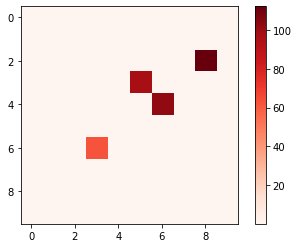

In [3]:
modulus = np.absolute(sky_image)
plt.imshow(modulus, cmap='Reds')
plt.colorbar();

In [4]:
visibilities = np.fft.fft2(sky_image).astype('complex64')
print(visibilities)

[[ 268.11548   +228.32397j   -197.29202     +8.75122j
    24.427212   -56.01342j   -185.72324    +21.292566j
   256.82852   -156.72624j     14.402734   +92.14559j
   -90.97663   +128.52939j    -51.716576   -30.660896j
    19.335176   -77.647354j   -57.640045  -157.38617j  ]
 [  24.983198  -278.13428j    151.39444   +317.80878j
   -99.224724   -39.183483j   -27.784018    -2.966018j
  -142.67183    -76.67421j    174.1488     -35.8964j
   131.07698     +2.3927581j -188.7609    +176.45404j
     0.76488805 -83.54673j    -23.686457   +20.136408j ]
 [-106.70233     +4.639155j   153.58884   -257.60754j
    13.588361  +252.3616j      -1.3533509  +48.797092j
   -91.61512    -60.66047j    -59.9381     -61.086376j
    45.746098   -56.63649j    268.4947     +68.0348j
  -286.6281     +88.229065j    64.87166    -26.330038j ]
 [  13.567059   +70.198105j   -95.38944    -69.299484j
   176.12286   -152.95581j      9.890653  +105.964226j
   -43.12327   +190.32993j    -40.79692   -157.08623j
   -71.1513   

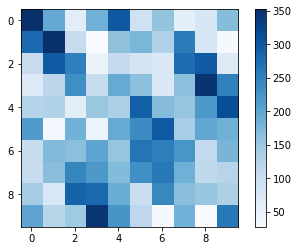

In [5]:
modulus = np.absolute(visibilities)
plt.imshow(modulus, cmap='Blues')
plt.colorbar();

In [6]:
sanity = np.fft.ifft2(visibilities).astype('complex64')

test1_real = ((sky_image.real - sanity.real)**2).mean()
test1_imag = ((sky_image.imag - sanity.imag)**2).mean()
 
print('Reals MSE: '+ str(test1_real))
print('Imaginaries MSE: '+ str(test1_imag))

Reals MSE: 1.4126818e-13
Imaginaries MSE: 9.8567896e-14


In [7]:
print( 'Encodes log2(n) qubits: ' + str(math.log2(n*n)) )

Encodes log2(n) qubits: 6.643856189774724


Wires: range(0, 7)
100
128


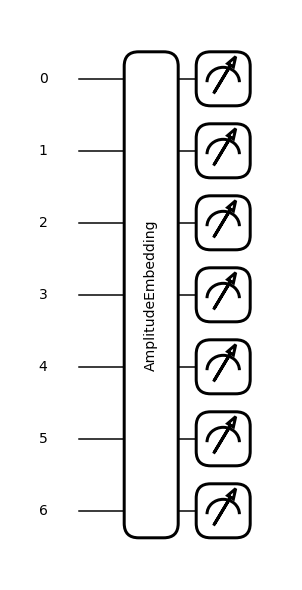

In [8]:
n_n = visibilities.shape[0]*visibilities.shape[1]
inp = visibilities.flatten()

norm = qml.math.sum(qml.math.abs(inp) ** 2)
#normalized_data = data / qml.math.sqrt(norm)

wires = range(math.ceil(math.log2(n_n)))
print( 'Wires: ' + str(wires) )
amp_dev = qml.device('default.qubit', wires)


@qml.qnode(amp_dev)
def amp_encoding(data):
    qml.AmplitudeEmbedding(data, wires, normalize=True, pad_with=0.)
    #qml.adjoint(qml.QFT)(wires=wires)
    return qml.state()

readout = amp_encoding(inp).astype('complex64')
qml.draw_mpl(amp_encoding)(inp)

print(len(inp))
print(len(readout))

readout.numpy()
readout = readout[:100]
readout = readout*qml.math.sqrt(norm)
readout = np.array(readout).reshape(sky_image.shape[0] , sky_image.shape[1])

In [9]:
#fidelity = readout
fidelity = np.fft.ifft2(readout).astype('complex64')

test2_real = ((sky_image.real - fidelity.real)**2).mean()
test2_imag = ((sky_image.imag - fidelity.imag)**2).mean()

print('Reals MSE: '+ str(test2_real))
print('Imaginaries MSE: '+ str(test2_imag))

Reals MSE: 9.659566e-13
Imaginaries MSE: 3.9907712e-13


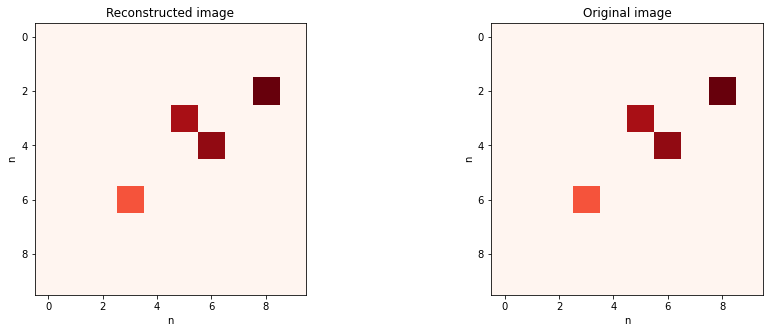

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
modulus1 = np.absolute(fidelity)
modulus2 = np.absolute(sky_image)

axs[0].imshow(modulus1, cmap='Reds')
axs[1].imshow(modulus2, cmap='Reds')

axs[0].set_title("Reconstructed image")
axs[1].set_title("Original image")

for ax in axs.flat:
    ax.set(xlabel='n', ylabel='n')